In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib

In [3]:
df_us = pd.read_csv('../../../df_us_bh_rxnfp_mhfp6_no_dupl.csv') #write the relevant paths to the data
df_rx = pd.read_csv('../../../df_rx_bh_rxnfp_mhfp6_no_dupl.csv')
df_hte = pd.read_csv('../../../df_hte_bh_rxnfp_mhfp6_no_dupl.csv')
df_az = pd.read_csv('../../../df_az_bh_rxnfp_mhfp6_no_dupl.csv')


delimiter = '.'
df_us['rxn'] = df_us.apply(lambda row: delimiter.join(row[['CONDITIONS', 'NO_MAP_NO_COND']]), axis=1)
df_us.dropna(subset = ['rxn'], inplace=True)
df_rx['rxn'] = df_rx.apply(lambda row: delimiter.join(row[['CONDITIONS', 'NO_MAP_NO_COND']]), axis=1)
df_rx.dropna(subset = ['rxn'], inplace=True)
df_hte['rxn'] = df_hte.apply(lambda row: delimiter.join(row[['CONDITIONS', 'NO_MAP_NO_COND']]), axis=1)
df_hte.dropna(subset = ['rxn'], inplace=True)
df_az['rxn'] = df_az.apply(lambda row: delimiter.join(row[['CONDITIONS', 'NO_MAP_NO_COND']]), axis=1)
df_az.dropna(subset = ['rxn'], inplace=True)

scaler = StandardScaler()
# Split the datasets into features and target variables
X4 = np.array([json.loads(x) for x in df_az["RXNFP_FP"]])
scaler.fit(X4)
X4 = scaler.transform(X4)
X4_2 = joblib.load("../../az_eln_drfp.pickle")
scaler.fit(X4_2)
X4_2 = scaler.transform(X4_2)
y4 = np.array(df_az.YIELD)



X1 = np.array([json.loads(x) for x in df_us["RXNFP_FP"]])
scaler.fit(X1)
X1 = scaler.transform(X1)
X1_2 = joblib.load("../../uspto_drfp.pickle")
scaler.fit(X1_2)
X1_2 = scaler.transform(X1_2)
y1 = np.array(df_us.YIELD)



X2 = np.array([json.loads(x) for x in df_rx["RXNFP_FP"]])
scaler.fit(X2)
X2 = scaler.transform(X2)
X2_2 = joblib.load("../../reaxys_drfp.pickle")
scaler.fit(X2_2)
X2_2 = scaler.transform(X2_2)
y2 = np.array(df_rx.YIELD)



X3 = np.array([json.loads(x) for x in df_hte["RXNFP_FP"]])
scaler.fit(X3)
X3 = scaler.transform(X3)
X3_2 = joblib.load("../../bh_hte_drfp.pickle")
scaler.fit(X3_2)
X3_2 = scaler.transform(X3_2)
y3 = np.array(df_hte.YIELD)


In [4]:
best_rfr = joblib.load("RFR_uspto_uspto_drfp_model.pkl")

In [7]:
X1_2train, X1_2test, y1_2train, y1_2test = train_test_split(X1_2, y1, test_size=0.2, random_state=42)

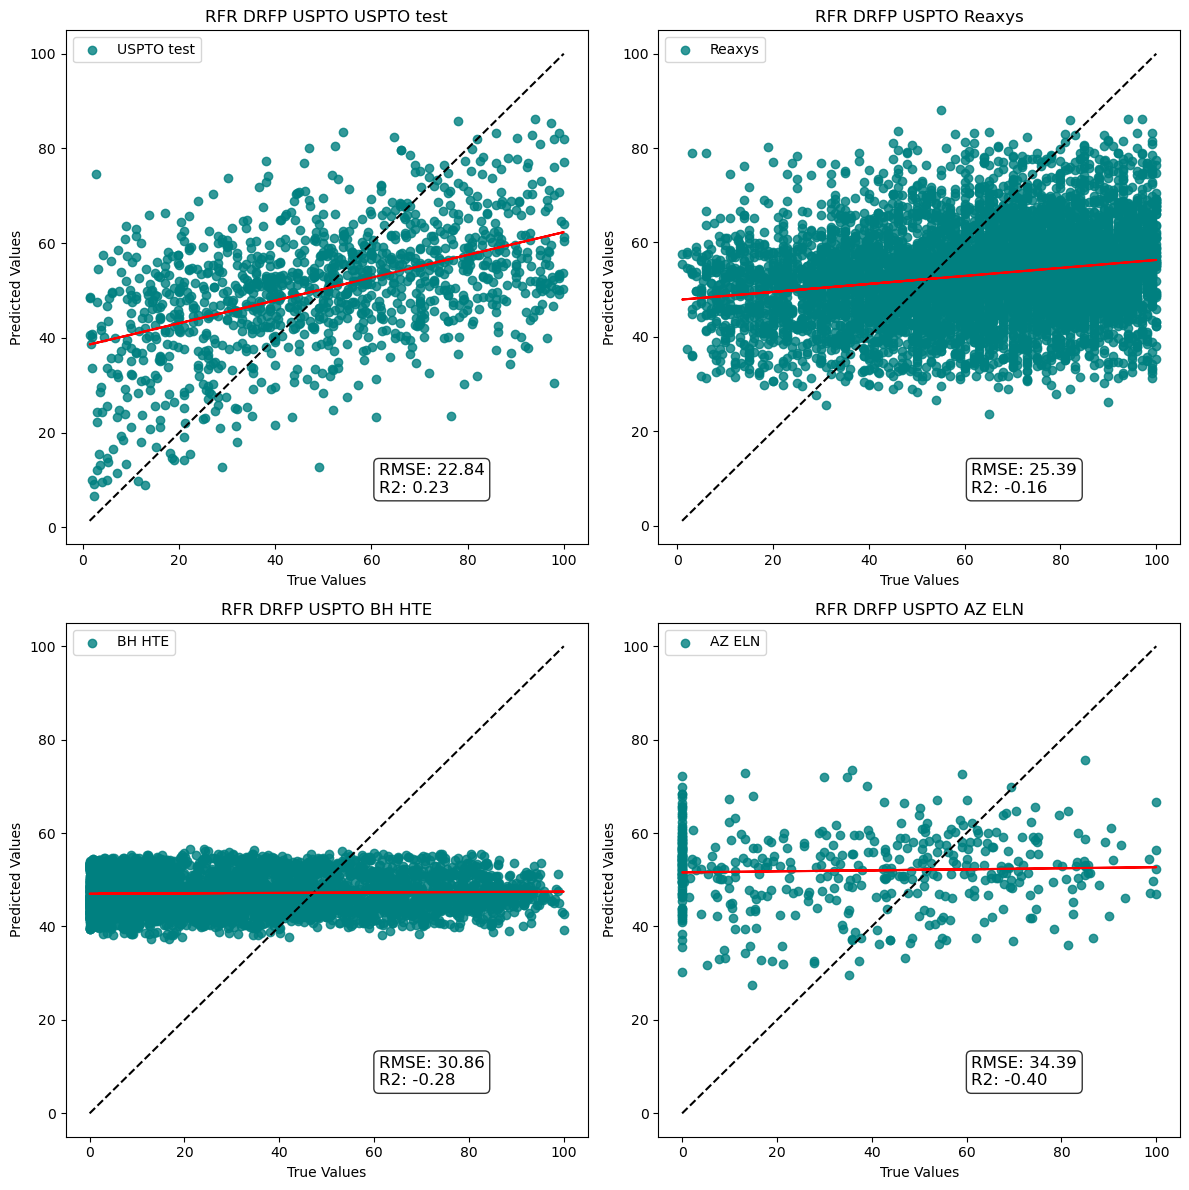

In [10]:
def plot_model(ax, y_true, y_predicted, title, l):
    rmse = np.sqrt(mean_squared_error(y_true, y_predicted))
    r2 = r2_score(y_true, y_predicted)

    # Plot the data
    ax.scatter(y_true, y_predicted, color='teal', label=l, alpha=0.8)

    # Plot the diagonal line
    ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='black', linestyle='--')

    # Plot the fitting line
    fitting_line = np.polyfit(y_true, y_predicted, 1)
    ax.plot(y_true, np.polyval(fitting_line, y_true), color='r')

    # Set labels and title
#    ax.set_xlabel('True Values', fontsize=12)
#    ax.set_ylabel('Predicted Values', fontsize=12)
#    ax.set_title(title)

    # Display RMSE and R2 coefficients in the plot
    text = f'RMSE: {rmse:.2f}\nR2: {r2:.2f}'
    props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
    ax.text(0.6, 0.1, text, transform=ax.transAxes, fontsize=12, bbox=props)


# Iterate over different models
names = ['RFR DRFP USPTO USPTO test', 'RFR DRFP USPTO Reaxys', 'RFR DRFP USPTO BH HTE', 'RFR DRFP USPTO AZ ELN']
labels = ['USPTO test', 'Reaxys', 'BH HTE', 'AZ ELN']
models = [best_rfr, best_rfr, best_rfr, best_rfr]
X = [X1_2test, X2_2, X3_2, X4_2]
Y = [y1_2test, y2, y3, y4]
# Create a figure and axis
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for i, (model, name, l, x, y) in enumerate(zip(models, names, labels, X, Y)):
    # Example y_predicted values for each model
    y_predicted = model.predict(x)
    y_true = y

    # Calculate the row and column indices for the current subplot
    row = i // 2
    col = i % 2

    # Call the plotting function for each model with the respective subplot
    plot_model(axs[row, col], y_true, y_predicted, name, l)

    # Set labels and title for each subplot
    axs[row, col].set_xlabel('True Values')
    axs[row, col].set_ylabel('Predicted Values')
    axs[row, col].set_title(f'{name}')

    # Add legend to each subplot
    axs[row, col].legend()


# Adjust spacing between subplots
plt.tight_layout()

# Save or show the plot
plt.savefig('publication_plot_uspto_testing.png', dpi=300)  # Save the plot as an image file
plt.show()